This notebook pulls the top N Individual stocks and tests cointegration

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Kalman
import Cointegration

N = 4
Tickers = [ 'NVDA',  'MSFT', 'AAPL','AMZN','META','AVGO','GOOGL','TSLA', 'GOOG', 'BRK-B',
            'JPM',   'LLY',  'V',   'NFLX','XOM', 'MA',   'ORCL', 'WMT','JNJ','PLTR',
            'COST',  'ABBV', 'HD',  'PG',  'BAC', 'GE',   'UNH',  'CVX','CSCO', 'WFC',
            'IBM',   'AMD',  'KO',  'PM',  'GS',  'ABT',  'CRM',  'RTX','CAT','LIN',
            'MCD',   'MRK',  'DIS', 'UBER','T',   'APP',  'MS',   'PEP','NOW','INTU',
            'MU',    'C',    'VZ',  'TMO', 'AXP', 'QCOM', 'BKNG', 'LRCX','BLK','GEV',
            'TXN',   'AMAT', 'BA',  'SCHW','TJX', 'ISRG', 'NEE',  'ACN','SPGI','AMGN',
            'APH',   'ANET', 'ADBE','INTC','ETN', 'PFE',  'PGR',  'BSX','KLAC', 'LOW',
            'UNP',   'GILD', 'PANW','COF', 'HON', 'SYK',  'DHR',  'BX','CRWD','MDT',
            'ADI',   'WELL', 'ADP', 'COP', 'TMUS','DE',   'CMCSA','MO','HOOD','PLD']

C:\Users\adamd\AppData\Local\Temp\ipykernel_16300\2850928291.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(Tickers[0:N], period='730d', interval='1h')['Close'].dropna()
[*********************100%***********************]  4 of 4 completed


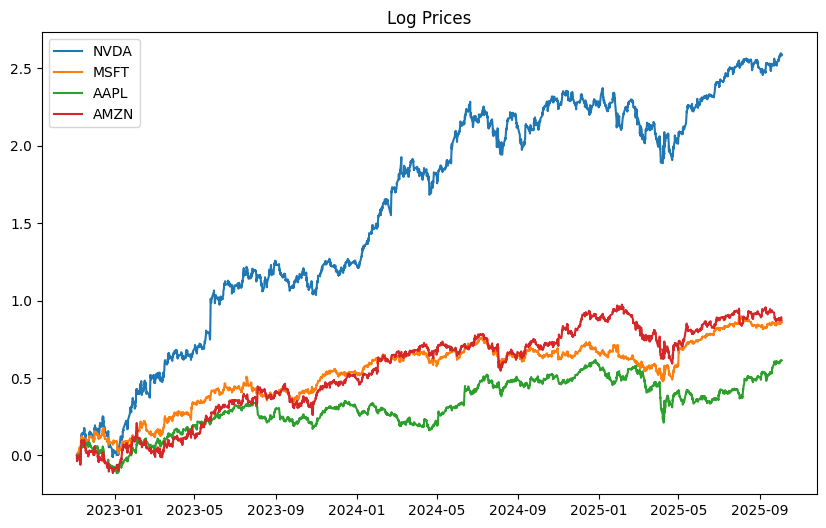

Processing pair: NVDA & MSFT
Processing pair: NVDA & AAPL
Processing pair: NVDA & AMZN
Processing pair: MSFT & AAPL
Processing pair: MSFT & AMZN
Processing pair: AAPL & AMZN


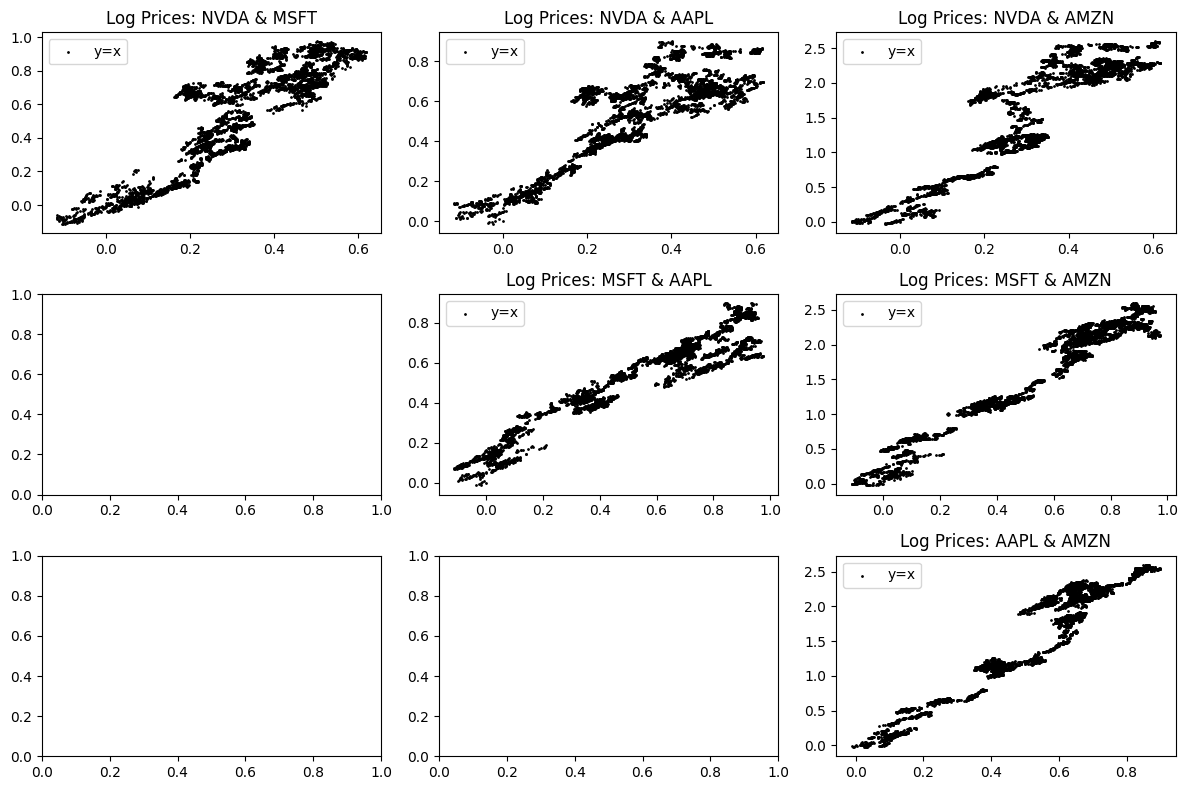

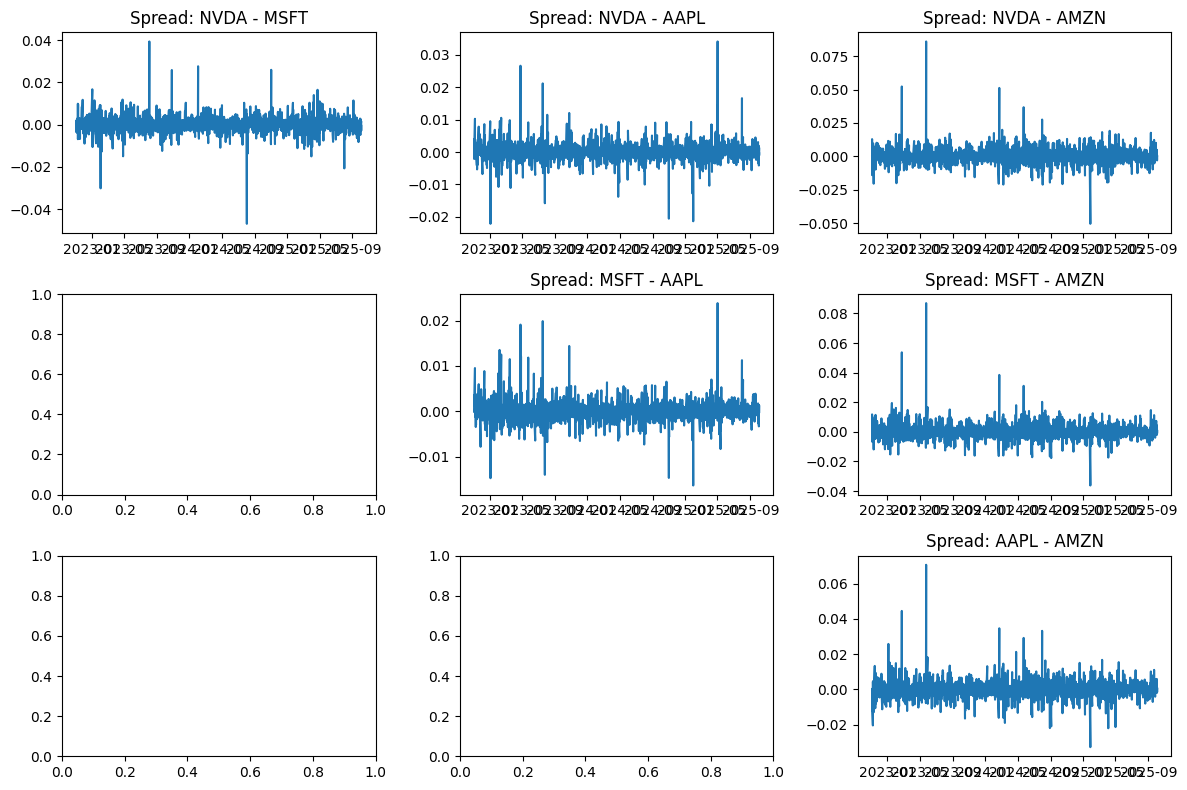

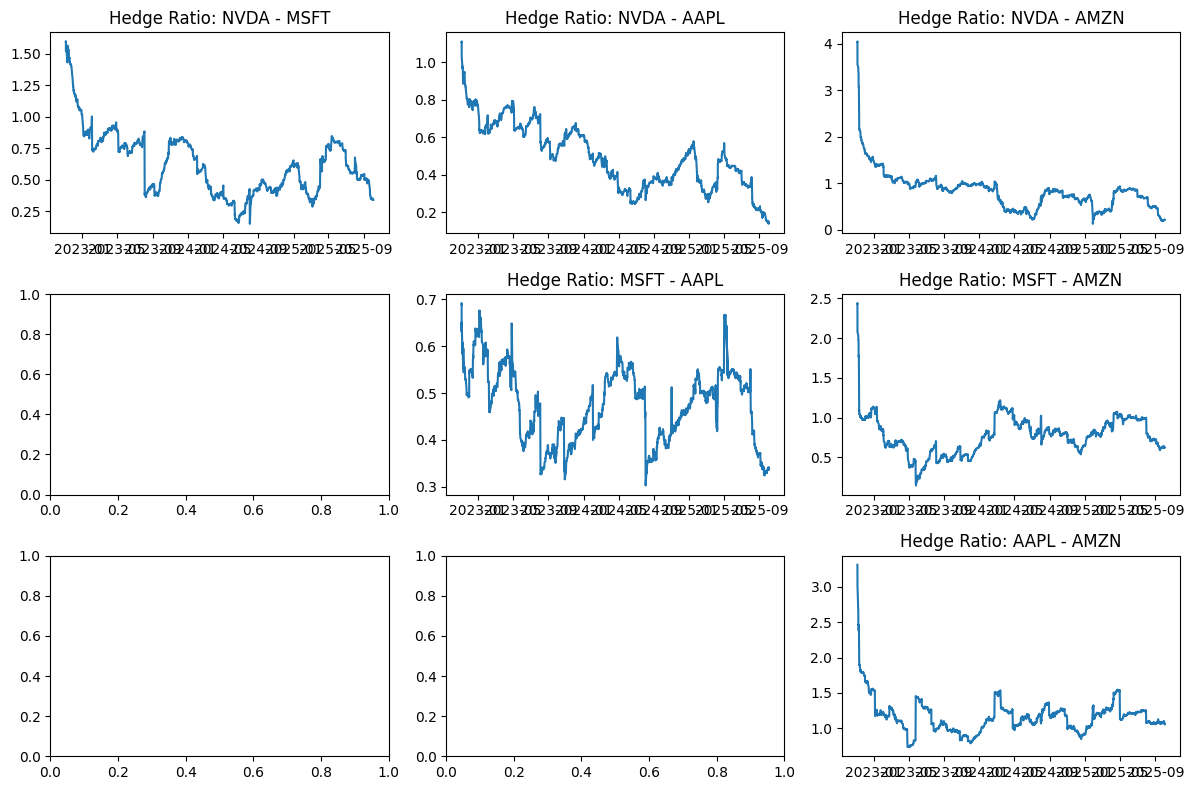

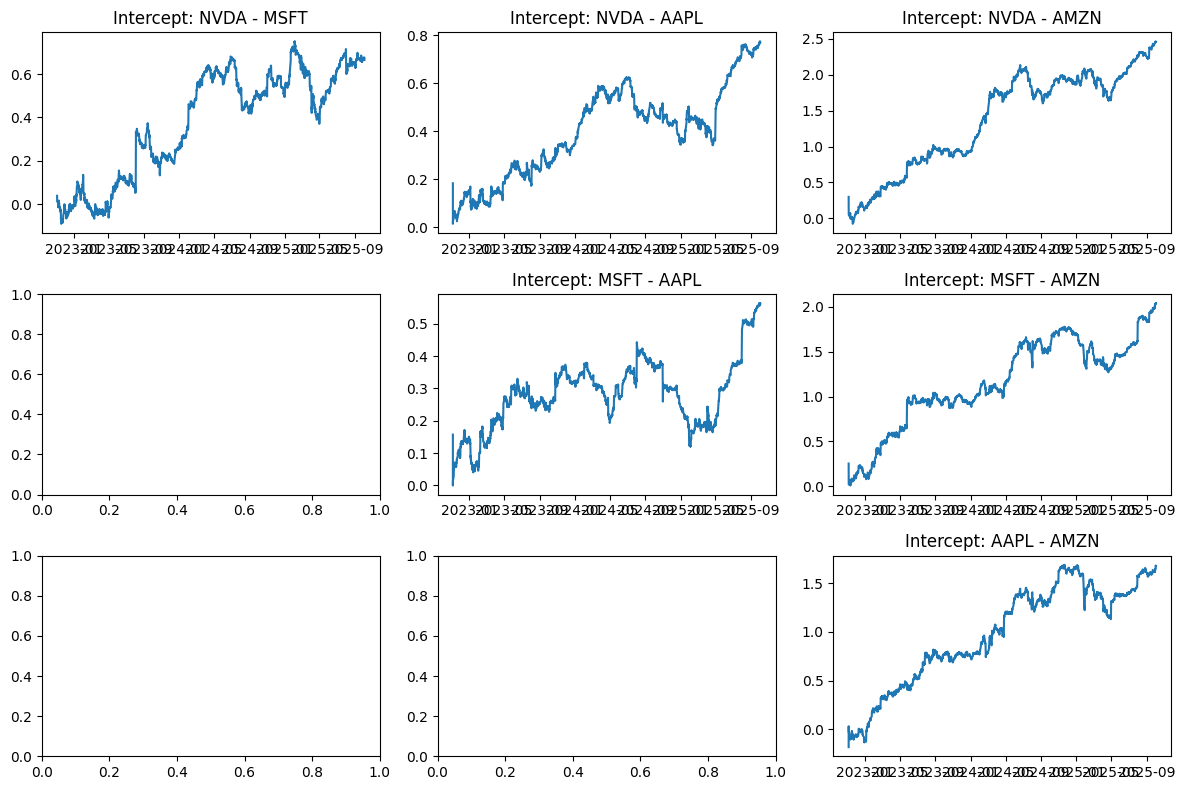

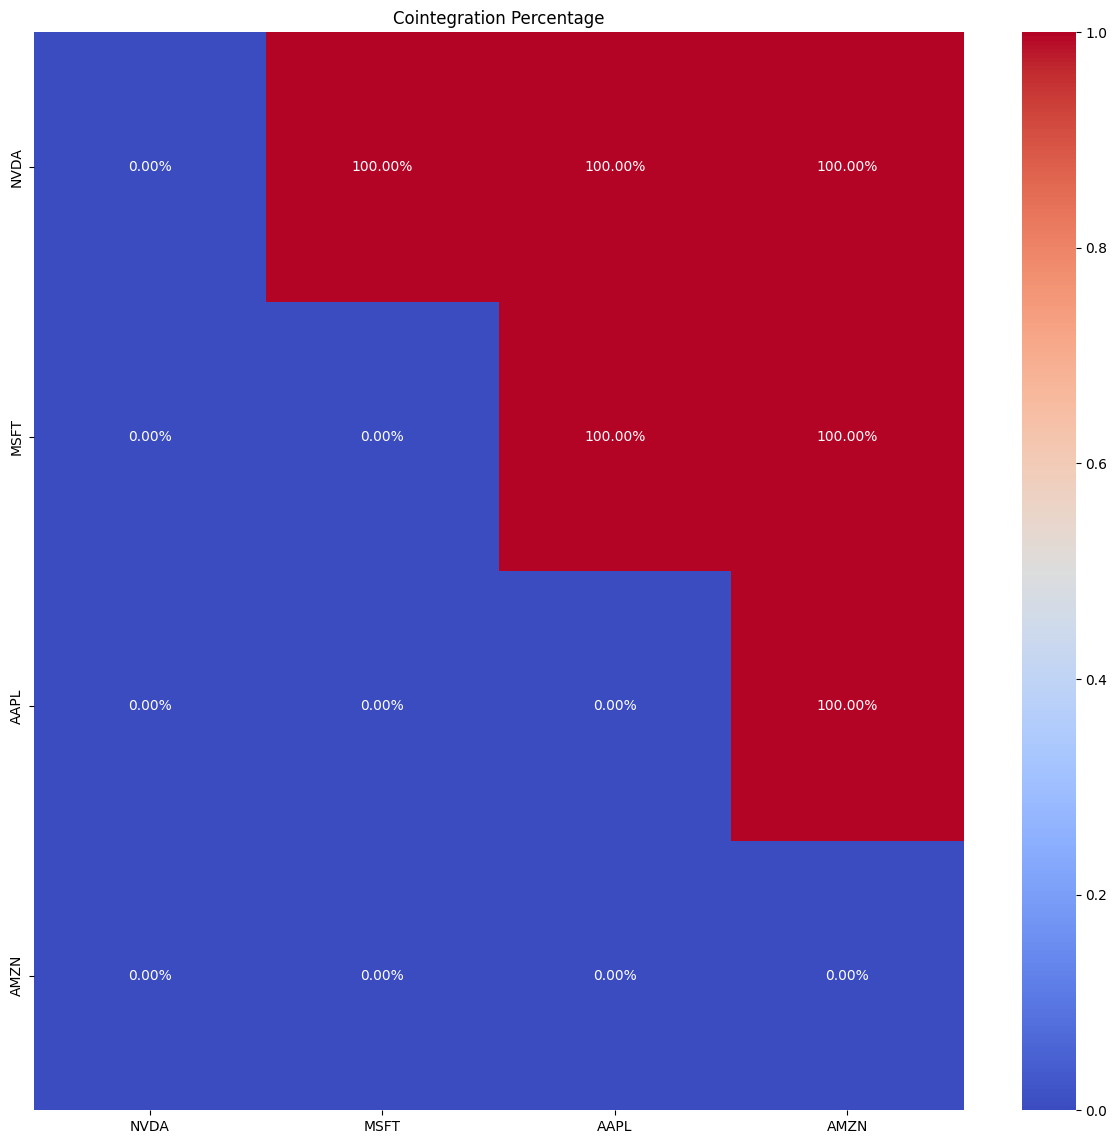

In [2]:
data = yf.download(Tickers[0:N], period='730d', interval='1h')['Close'].dropna()
logPrice = np.log(data) - np.log(data.iloc[0])
# Kalman.SpreadFit()


plt.figure(figsize=(10,6))
for ticker in Tickers[0:N]:
    plt.plot(logPrice[ticker], label=ticker)
plt.legend()
plt.title('Log Prices')
plt.show()


# plot spread on N(N-1)/2 subplots (skip i=j and j>i)
if N <= 6:
    num_pairs = N * (N - 1) // 2
    dim = N-1
    LogPriceFig, logprice_axes = plt.subplots(dim, dim, figsize=(12, 8))
    SpreadFig, spread_axes = plt.subplots(dim, dim, figsize=(12, 8))
    HedgeFig, hedge_axes = plt.subplots(dim, dim, figsize=(12, 8))
    InterceptFig, intercept_axes = plt.subplots(dim, dim, figsize=(12, 8))



Coint_percentage = np.empty((N,N))
adf_stat = np.empty((N,N))
coint_list = pd.DataFrame()
columns = logPrice.columns
for i in range(N):
    for j in range(i+1, N):
        print(f'Processing pair: {Tickers[i]} & {Tickers[j]}')
        Spread, theta = Kalman.SpreadFit(logPrice[columns[i]], logPrice[columns[j]])

        Coint_percentage[i,j], adf_stat[i,j] = Cointegration.augmented_dickey_fuller_test(Spread)
        coint_list = pd.concat([coint_list, pd.DataFrame({'Ticker1': [Tickers[i]], 'Ticker2': [Tickers[j]], 'Coint_Percentage': [Coint_percentage[i,j]]})])


        # HR, I = Cointegration.rolling_linear_regression(logPrice[columns[i]], logPrice[columns[j]], period=20)

        if N <= 6:
            logprice_axes[i,j-1].scatter(logPrice[columns[i]].values, logPrice[columns[j]].values, c='k', s=1, label='y=x')
            logprice_axes[i,j-1].set_title(f'Log Prices: {Tickers[i]} & {Tickers[j]}')
            logprice_axes[i,j-1].legend()

            spread_axes[i,j-1].plot(Spread)
            spread_axes[i,j-1].set_title(f'Spread: {Tickers[i]} - {Tickers[j]}')

            hedge_axes[i,j-1].plot(theta['Hedge Ratio'])
            # hedge_axes[i,j-1].plot(HR, linestyle='--', color='orange', label='Rolling HR (20)')
            # hedge_axes[i,j-1].legend()
            hedge_axes[i,j-1].set_title(f'Hedge Ratio: {Tickers[i]} - {Tickers[j]}')

            intercept_axes[i,j-1].plot(theta['Intercept'])
            # intercept_axes[i,j-1].plot(I, linestyle='--', color='orange', label='Rolling Intercept (20)')
            # intercept_axes[i,j-1].legend()
            intercept_axes[i,j-1].set_title(f'Intercept: {Tickers[i]} - {Tickers[j]}')


if N <= 6:
    LogPriceFig.tight_layout()
    SpreadFig.tight_layout()
    HedgeFig.tight_layout()
    InterceptFig.tight_layout()

plt.figure(figsize=(15,14))
sns.heatmap(Coint_percentage, xticklabels=Tickers[0:N], yticklabels=Tickers[0:N], annot=True, fmt=".2%", cmap='coolwarm')
plt.title('Cointegration Percentage')
plt.show()

In [3]:
coint_list = coint_list.sort_values(by='Coint_Percentage', ascending=False).reset_index(drop=True)
coint_list

,Ticker1,Ticker2,Coint_Percentage
0,NVDA,MSFT,1.0
1,NVDA,AAPL,1.0
2,NVDA,AMZN,1.0
3,MSFT,AAPL,1.0
4,MSFT,AMZN,1.0
5,AAPL,AMZN,1.0
